# Deep Reinforcement Learning <em> in Action </em> 
## Ch. 4 - Policy Gradients

In [1]:
import gym
# -*- coding: utf-8 -*-
import numpy as np
import torch
from matplotlib import pylab as plt

In [2]:
def running_mean(x, N=50):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

In [3]:
l1 = 4
l2 = 150
l3 = 2

model = torch.nn.Sequential(
    torch.nn.Linear(l1, l2),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(l2, l3),
    torch.nn.Softmax()
)

def loss_fn(preds, r): 
    #pred is output from neural network, a is action index
    #r is return (sum of rewards to end of episode), d is discount factor
    return -torch.sum(r * torch.log(preds)) #element-wise multipliy, then sum

learning_rate = 0.0009
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [4]:
def discount_rewards(rewards, gamma=0.99): #rewards is a sequence e.g. [50,49,48,47,...]
    lenr = len(rewards)
    d_rewards = torch.pow(gamma,torch.arange(lenr)) * rewards #discounted rewards
    d_rewards = (d_rewards - d_rewards.mean()) / (d_rewards.std() + 1e-07)
    return d_rewards

In [5]:
env = gym.make('CartPole-v0')
MAX_DUR = 200
MAX_EPISODES = 500
gamma_ = 0.99
losses = []
time_steps = []
for episode in range(MAX_EPISODES):
    state1 = env.reset()
    done = False
    t = 0
    obs = [] # list of state observations
    actions = [] #list of actions
    for t in range(MAX_DUR): #while in episode
        pred = model(torch.from_numpy(state1).float())
        action = np.random.choice(np.array([0,1]), p=pred.data.numpy())
        state2, reward, done, info = env.step(action)
        obs.append(state1)
        actions.append(action)
        state1 = state2
        if done:
            break
    time_steps.append(len(obs))
    #print("Episode finished after {} timesteps".format(t+1))
    # Optimize policy network with full episode
    ep_len = len(obs) # episode length
    rewards = torch.arange(ep_len, 0, -1) #list of rewards
    preds = torch.zeros(ep_len)
    for j in range(ep_len): #for each step in episode
        d_rewards = discount_rewards(rewards, gamma_)
        state = obs[j]
        action = int(actions[j])
        pred = model(torch.from_numpy(state).float())
        preds[j] = pred[action]
        
    loss = loss_fn(preds, d_rewards)
    losses.append(loss)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
        
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/Users/alexzai/anaconda3/lib/python3.6/site-packages/torch/nn/modules/container.py:91: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


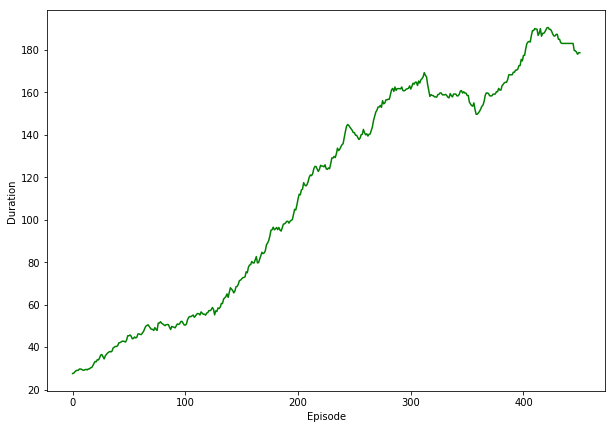

In [6]:
plt.figure(figsize=(10,7))
plt.ylabel("Duration")
plt.xlabel("Episode")
plt.plot(running_mean(time_steps, 50), color='green')
plt.savefig("PG_score_plot1.pdf", format="pdf")

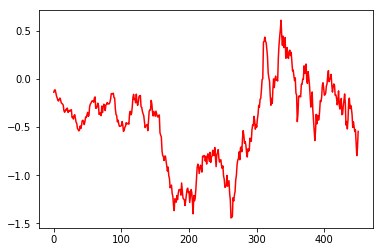

In [7]:
plt.close()
plt.plot(running_mean(losses, N=50), color='red')

In [8]:
env.close()

## Actor-Critic

In [9]:
l1 = 4
l2 = 150
l3 = 2

actor_model = torch.nn.Sequential(
    torch.nn.Linear(l1, l2),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(l2, l3),
    torch.nn.Softmax()
)

critic_model = torch.nn.Sequential(
    torch.nn.Linear(l1, l2),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(l2, 1),
    torch.nn.LeakyReLU(),
)

lr_actor = 0.0009 #0.0009
lr_critic = 0.001 #0.001
optimizer_actor = torch.optim.Adam(actor_model.parameters(), lr=lr_actor)
optimizer_critic = torch.optim.Adam(critic_model.parameters(), lr=lr_critic)

In [10]:
env = gym.make('CartPole-v0')
observation = env.reset()
#state, reward, done, info = env.step(1)
#observation.shape # (4,)
critic_model(torch.from_numpy(observation).float())

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


tensor([ 0.1306])

In [11]:
def loss_fn_actor(pred, delta, discount): 
    return -1 * discount * delta * torch.log(pred)

loss_fn_critic = torch.nn.MSELoss()

In [12]:
env = gym.make('CartPole-v0')
MAX_DUR = 250
MAX_EPISODES = 750
gamma = 0.99
losses_actor = []
losses_critic = []
time_steps = []
for episode in range(MAX_EPISODES):
    state1 = env.reset()
    done = False
    t = 0
    discount = 1
    while not done: #while in episode
        state1_th = torch.from_numpy(state1).float() #convert to PyTorch tensor
        action_pred = actor_model(state1_th)
        action = np.random.choice(np.array([0,1]), p=action_pred.data.numpy())
        
        state2, reward, done, info = env.step(action) #Take action, observe new state and reward
        psuedoreward = t/MAX_DUR if not done else -1
        psuedoreward = torch.tensor(psuedoreward).float()
        state2_th = torch.from_numpy(state2).float()
        critic_pred1 = critic_model(state1_th) #State-value prediction for original state
        critic_pred2 = critic_model(state2_th) #State-value prediction for new state

        delta = psuedoreward + (gamma * reward * critic_pred2) - critic_pred1
        delta = delta.detach() #Need to detach because we're using critic_pred2 in 2 places
        
        #Training
        critic_target = psuedoreward if done else psuedoreward + gamma * critic_pred2
        loss_actor = loss_fn_actor(action_pred[action], delta, discount)
        loss_critic = loss_fn_critic(critic_pred1, psuedoreward)
        losses_actor.append(loss_actor)
        losses_critic.append(loss_critic)
        
        optimizer_actor.zero_grad()
        optimizer_critic.zero_grad()
        loss_actor.backward()
        loss_critic.backward()
        
        optimizer_actor.step()
        optimizer_critic.step()
        
        #End Training
        discount = gamma * discount
        state1 = state2
        t += 1
        if t > MAX_DUR:
            break;
    time_steps.append(t+1)
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/Users/alexzai/anaconda3/lib/python3.6/site-packages/torch/nn/modules/container.py:91: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


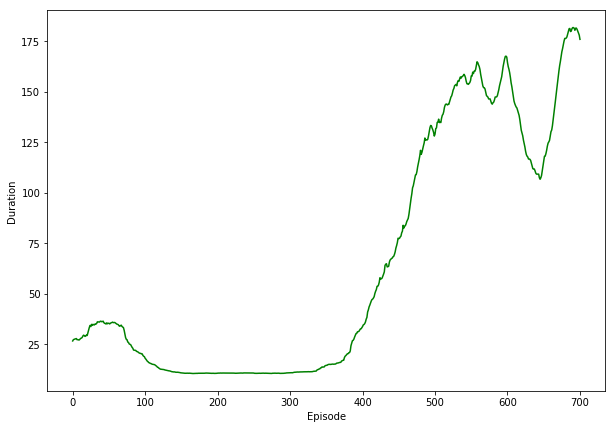

In [15]:
plt.figure(figsize=(10,7))
plt.ylabel("Duration")
plt.xlabel("Episode")
plt.plot(running_mean(time_steps, 50), color='green')
plt.savefig("PGac_score_plot1.pdf", format="pdf")

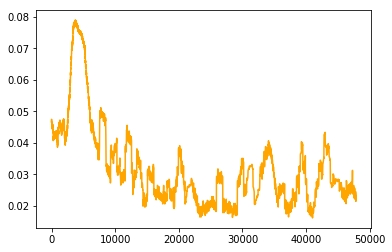

In [16]:
plt.close()
plt.plot(running_mean(losses_critic, N=1000), color='orange')

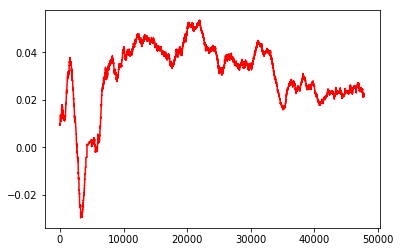

In [17]:
plt.close()
plt.plot(running_mean(losses_actor, N=1000), color='red')

## Actor-Critic with Experience Replay

In [18]:
l1 = 4
l2 = 150
l3 = 2

actor_model = torch.nn.Sequential(
    torch.nn.Linear(l1, l2),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(l2, l3),
    torch.nn.Softmax()
)

critic_model = torch.nn.Sequential(
    torch.nn.Linear(l1, l2),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(l2, 1),
    torch.nn.LeakyReLU(),
)

lr_actor = 0.0009 #0.0009
lr_critic = 0.001 #0.001
optimizer_actor = torch.optim.Adam(actor_model.parameters(), lr=lr_actor)
optimizer_critic = torch.optim.Adam(critic_model.parameters(), lr=lr_critic)

In [19]:
def loss_fn_actor(pred, delta, discount): 
    return -1 * discount * delta * torch.sum(torch.log(pred))

loss_fn_critic = torch.nn.MSELoss()